In [1]:
%cd pandas
!pip install -r requirements-dev.txt
!pip install cython
!python -m pip install -e . --no-build-isolation
%cd ../

/Users/hectorandac/Documents/School/Semester2/SoftwareSystems/Presentation1/pandas
  Using cached black-23.3.0-cp310-cp310-macosx_10_16_universal2.whl (2.7 MB)
  Attempting uninstall: black
    Found existing installation: black 23.1.0
    Uninstalling black-23.1.0:
      Successfully uninstalled black-23.1.0
Obtaining file:///Users/hectorandac/Documents/School/Semester2/SoftwareSystems/Presentation1/pandas
  Checking if build backend supports build_editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pandas (pyproject.toml) ... done
  Created wheel for pandas: filename=pandas-2.1.0.dev0+982.ga8d6148f5e.dirty-cp310-cp310-macosx_13_0_arm64.whl size=33850 sha256=8c9ec87bc52f9ff8e59b29a4d240364e51bb5d2e51cae2e4ab0966897f6a2866
  Stored in directory: /private/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/pip-ephem-wheel-cache-lptnp0ot/wheels/b8/dd/b2/09d53981b5f14fd392dc70275a67910851cd74334f6dc4075c
Successfully built pandas
  Attempting unin

In [2]:
!pip install -r requirements.txt

  Using cached black-23.1.0-cp310-cp310-macosx_10_16_universal2.whl (2.6 MB)
  Attempting uninstall: black
    Found existing installation: black 23.3.0
    Uninstalling black-23.3.0:
      Successfully uninstalled black-23.3.0


In [3]:
import sys
sys.path.append('/Users/hectorandac/Documents/School/Semester2/SoftwareSystems/Presentation1/pandas')
import pandas as pd
from fuzzingbook.Fuzzer import Fuzzer
from fuzzingbook.Fuzzer import Runner
from fuzzingbook.Coverage import Coverage, Location
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable, Set, Any, Dict
import copy
from data_frame_method_args import DataFrameMethodArgs

In [4]:
print(pd.__version__)
print(pd.__file__)

2.1.0.dev0+982.ga8d6148f5e.dirty
/Users/hectorandac/Documents/School/Semester2/SoftwareSystems/Presentation1/pandas/pandas/__init__.py


In [5]:
import grpc
import sys
import pandas_service_pb2
import pandas_service_pb2_grpc

class PandasClient:
    _instance = None
    _channel = None
    _stub = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(PandasClient, cls).__new__(cls)
            # Initialize the gRPC channel and stub here, so it's done only once.
            cls._channel = grpc.insecure_channel('localhost:50051')
            cls._stub = pandas_service_pb2_grpc.PandasServiceStub(cls._channel)
        return cls._instance

    def run_method(self, input_json):
        # Create a valid request message
        method_request = pandas_service_pb2.MethodRequest(input_json=input_json)

        # Make the call
        response = self._stub.RunMethod(method_request)

        # Return the result
        return response

In [6]:
import psutil
import time
import matplotlib.pyplot as plt
import threading

class ResourceMonitor:
    def __init__(self):
        self.cpu_percentages = []
        self.memory_percentages = []
        self.timestamps = []
        self.stop_event = threading.Event()
        self.thread = threading.Thread(target=self.monitor)

    def monitor(self):
        while not self.stop_event.is_set():
            self.cpu_percentages.append(psutil.cpu_percent())
            self.memory_percentages.append(psutil.virtual_memory().percent)
            self.timestamps.append(time.time())
            time.sleep(1)  # sleep for 1 second

    def start(self):
        self.thread.start()

    def stop(self):
        self.stop_event.set()
        self.thread.join()

    def plot(self):
        # Plot CPU usage over time
        plt.figure(figsize=(10, 5))
        plt.plot(self.timestamps, self.cpu_percentages, label='CPU')
        plt.plot(self.timestamps, self.memory_percentages, label='Memory')
        plt.legend(loc='upper right')
        plt.title('Resource Utilization Over Time')
        plt.xlabel('Time (s)')
        plt.ylabel('Utilization (%)')
        plt.show()

# Usage:
monitor = ResourceMonitor()
monitor.start()


In [7]:
def mutate_dataframe(df: pd.DataFrame):
    df_copy = df.copy()
    
    num_cols = len(df_copy.columns)
    num_rows = len(df_copy)
    mutation_type = random.randint(0, 4)
    
    # Add a row
    if mutation_type == 0:
        new_row = pd.DataFrame([[np.nan]*num_cols], columns=df_copy.columns)
        df_copy = pd.concat([df_copy, new_row], ignore_index=True)

    # Remove a row
    elif mutation_type == 1 and num_rows > 1:
        df_copy = df_copy.drop(random.randint(0, num_rows - 1))
    
    # Change a value
    elif mutation_type == 2 and num_rows > 0 and num_cols > 0:
        row_idx = random.randint(0, num_rows-1)
        col_idx = random.randint(0, num_cols-1)
        col_type = df_copy.dtypes[col_idx]
        if col_type == np.dtype('float64') or col_type == np.dtype('int64'):
            df_copy.iat[row_idx, col_idx] = random.random() * 100
        elif col_type == np.dtype('O'):
            df_copy.iat[row_idx, col_idx] = ''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=5))
        
    # Add a column with random numbers
    elif mutation_type == 3:
        random_numbers = np.random.rand(num_rows)
        df_copy[f'random_{num_cols}'] = random_numbers

    # Add a row with random numbers/values depending on column data type
    elif mutation_type == 4:
        new_row_data = []
        for col in df_copy.columns:
            col_type = df_copy[col].dtype
            if col_type == np.dtype('float64') or col_type == np.dtype('int64'):
                new_row_data.append(random.random() * 100)
            elif col_type == np.dtype('O'):
                new_row_data.append(''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=5)))
        new_row = pd.DataFrame([new_row_data], columns=df_copy.columns)
        df_copy = pd.concat([df_copy, new_row], ignore_index=True)

    df_copy = df_copy.reset_index(drop=True)
        
    return df_copy

In [8]:
class MutationFuzzer(Fuzzer):
    """Base class for mutational fuzzing"""

    def __init__(self, seed: List[DataFrameMethodArgs], min_mutations: int = 2, max_mutations: int = 10) -> None:
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()

    def reset(self) -> None:
        self.population = self.seed.copy()
        self.seed_index = 0
    
    def mutate(self, df: DataFrameMethodArgs) -> DataFrameMethodArgs:
        df.mutate()
        return df
        
    
    def create_candidate(self) -> DataFrameMethodArgs:
        """Create a new candidate by mutating a population member"""
        candidate = random.choice(self.population)
        trials = random.randint(self.min_mutations, self.max_mutations)
        for _ in range(trials):
            candidate = self.mutate(candidate)
        return candidate

    def fuzz(self) -> DataFrameMethodArgs:
        if self.seed_index < len(self.seed):
            # Still seeding
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()
        return self.inp


In [9]:
class DataFrameRunner(Runner):
    def __init__(self, oracle_and_compare: Callable, instance_method: bool = True) -> None:
        """Initialize with a DataFrame method to be executed, and a combined oracle and comparator function"""
        self.oracle_and_compare = oracle_and_compare
        self.instance_method = instance_method

    def run_function(self, inp: DataFrameMethodArgs) -> Any:
        # Check the function style and call the method accordingly
        if self.instance_method:
            method = getattr(inp.df, inp.method)
            return method(**inp.args)
        
        # TODO: Define class methods here

    def run(self, inp: DataFrameMethodArgs) -> Tuple[Any, str]:
        method_result = None
        try:
            method_result = self.run_function(inp)
        except Exception as e:
            method_result = str(e)
            # return None, self.FAIL
        
        if self.oracle_and_compare(inp, method_result):
            outcome = self.PASS
        else:
            outcome = self.FAIL

        return method_result, outcome


In [10]:
class DataFrameCoverageRunner(DataFrameRunner):
    def run_function(self, inp: DataFrameMethodArgs) -> Any:
        with Coverage() as cov:
            try:
                result = super().run_function(inp)
            except Exception as exc:
                self._coverage = cov.coverage()
                raise exc

        self._coverage = cov.coverage()
        return result

    def coverage(self) -> Set[Location]:
        return self._coverage

In [11]:
import time

class DataFrameMutationCoverageFuzzer(MutationFuzzer):
    """Fuzz with mutated inputs based on coverage"""

    def reset(self) -> None:
        super().reset()
        self.coverages_seen: Set[frozenset] = set()
        self.cumulative_coverage = []
        self.population = []
        self.bug_counter = 0
        self.bug_discovery_time = []
        self.cycle_times = []
        self.start_time = time.time()

    def bug_rate(self) -> str:
        if self.bug_discovery_time:
            total_bugs = self.bug_discovery_time[-1][0]
            total_time = self.bug_discovery_time[-1][1]
            bugs_per_second = total_bugs / total_time
            return f"Bug discovery rate: {bugs_per_second:.2f} bugs/second"
        else:
            return "No bugs were discovered during this fuzzing campaign"
        
    def avg_time_per_cycle(self) -> float:
        """Return the average time per cycle in seconds"""
        if self.cycle_times:
            return sum(self.cycle_times) / len(self.cycle_times)
        else:
            return 0.0

    def run(self, runner: DataFrameCoverageRunner) -> Any:  # type: ignore
        """Run function(inp) while tracking coverage.
           If we reach new coverage,
           add inp to population and its coverage to population_coverage
        """
        start_cycle_time = time.time()
        result, outcome = super().run(runner)
        end_cycle_time = time.time()
        self.cycle_times.append(end_cycle_time - start_cycle_time)
        new_coverage = frozenset(runner.coverage())
        self.cumulative_coverage.append((len(self.coverages_seen), outcome))
        if outcome == Runner.PASS and new_coverage not in self.coverages_seen:
            inp_copy = copy.deepcopy(self.inp)
            self.population.append(inp_copy)
            self.coverages_seen.add(new_coverage)
        elif outcome != Runner.PASS:
            self.bug_counter += 1
            elapsed_time = time.time() - self.start_time
            self.bug_discovery_time.append((self.bug_counter, elapsed_time))

        return result


In [12]:
import subprocess
import json

def pandas_oracle(df: DataFrameMethodArgs, result) -> bool:
    def convert_json_to_dataframe(json_string):
        # Attempt to load the JSON string into a dictionary
        data_dict = json.loads(json_string)
        
        # Check if all values in the dictionary are scalars (not lists or dicts)
        if all(isinstance(value, (int, float, str)) for value in data_dict.values()):
            # Convert the dictionary of scalars to a DataFrame
            return pd.DataFrame([data_dict]).squeeze()
        else:
            # Convert the JSON string to a DataFrame using pd.read_json()
            return pd.read_json(json_string)
    
    input_json = None
    try:
        input_json = json.dumps(df.to_dict())
    except Exception as e:
        print(df)

    client = PandasClient()
    healthy_result_obj = client.run_method(input_json)
    if healthy_result_obj.status == "error":
        print(result)
        print(healthy_result_obj.error_message)
        if isinstance(healthy_result_obj.error_message, str):
            return result == healthy_result_obj.error_message
        else:
            return False
    else:
        try:
            healthy_result = convert_json_to_dataframe(healthy_result_obj.result)
            print(healthy_result)
            print(result)
            print(result.equals(healthy_result))
            return result.equals(healthy_result)
        except Exception as e:
            print(e)
            print(healthy_result_obj.result)
            return False

def exception_oracle(df: DataFrameMethodArgs, result) -> bool:
    return result is not None

In [13]:
seed_input = DataFrameMethodArgs(pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [10, 20, 30, 40, 50],
    'C': [8, 7, 6, 5, 4]
}), "sort_values", {'by': 'A', 'axis': 0, 'ascending': True, 'inplace': False, 'kind': 'quicksort', 'na_position': 'first', 'ignore_index': False})
mutation_fuzzer = DataFrameMutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(DataFrameCoverageRunner(pandas_oracle), trials=10000)

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
                               A   B  C
1970-01-01 00:00:00.372374028  3  30  6
          A   B  C
0.372374  3  30  6
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A     4
B    40
C     7
Name: 0, dtype: int64
A     4
B    40
C     7
Name: 0.841655448068753, dtype: int64
True
    A_left  B_left  C_left  A_right  B_right  C_right
0        1      10       8        1       10        8
1        1      10       8        2       20        7
2        1      

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C
0  1  10  8
1 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30      

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2     

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

                               A   B  C
1970-01-01 00:00:00.187802598  2  20  5
          A   B  C
0.187803  2  20  5
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
0    10
1    20
2    30
3    40
4    50
Name: 0, dtype: int64
0    10
1    20
2    30
3    40
4    50
Name: 0.9602308877024015, dtype: int64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
True
   A_left  B_l

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
True
      A    B     C
A   2.5   25  -2.5
B  25.0

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False  False
1  False  False   True
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False   True
2  False  False  False
3  False  False  False
4  False  False  False
True
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
                               A   B  C
1970-01-01 00:00:00.919957697  5  50  4
1970-01-01 00:00:00.433214396  3  30  6
          A   B  C
0.919958  5  50  4
0.433214  3  30  6
False
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
0    8
1    7
2    6
3    5
4    4
Name: 0, dtype: int64
0    8
1    7
2    6
3    5
4    4
Name: 0.44984924937428994, dtype: int64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
                                0   1   2   3   4
1970-0

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False   True
1  False  False  False
2  False  False   True
3  False  False  False
4  False  False  False
       A      B      C
0  False  False   True
1  False  False  False
2  False  False   True
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
A     4
B    40
C     5
Name: 0, dtype: int64
A     4
B    40
C     5
Name: 0.668087103351321, dtype: int64
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
     

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
                                0   1   2   3   4
1970-01-01 00:00:00.951313913  10  20  30  40  50
1970-01-01 00:00:00.258246243   8   7   6   5   4
1970-01-01 00:00:00.769085228  10  20  30  40  50
           0   1   2   3   4
0.951314  10  20  30  40  50
0.258246   8   7   6   5   4
0.769085  10  20  30  40  50
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN Na

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A_left  B_left  C_left  A_y  B_y  C_y
0        1      10       8    1   10    8
1        1      10       8    2   20    7
2        1      10       8    3   30    6
3        1      10       8    4   40    5
4        1      10       8    5   50    4
5        2      20       7    1   10    8
6        2      20       7    2   20    7
7        2      20       7    3   30    6
8        2      20       7    4   40    5
9        2      20       7    5   50    4
10       3      30       6    1   10    8
11       3      30       6    2   20    7
12       3      30       6    3   30    6
13       3      30       6    4   40    5
14       3      30       6    5   50    4
15       4      40       5    1   10    8
16       4      40       5    2   20    7
17       4      40       5    3   30    6
18

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C
0  1  10  8
1  2  20  7
2  3 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: fl

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
       A      B      C
0  False   True  False
1  False  False   True
2  False  False   True
3   True  False  False
4  False  False   True
       A      B      C
0  False   True  False
1  False  False   True
2  False  False   True
3   True  False  False
4

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

                               A   B  C
1970-01-01 00:00:00.491632432  2  20  7
1970-01-01 00:00:00.965850413  4  40  5
1970-01-01 00:00:00.394768417  2  20  7
          A   B  C
0.491632  2  20  7
0.965850  4  40  5
0.394768  2  20  7
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
                               0  1  2  3  4
1970-01-01 00:00:00.278207034  1  2  3  4  5
1970-01-01 00:00:00.740344882  8  7  6  5  4
1970-01-01 00:00:00.305149466  1  2  3  4  5
          0  1  2  3  4
0.278207  1  2  3  4  5
0.740345  8  7  6  5  4
0.305149  1  2  3  4  5
False
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

                               0  1  2  3  4
1970-01-01 00:00:00.203607693  1  2  3  4  5
1970-01-01 00:00:00.369276136  1  2  3  4  5
          0  1  2  3  4
0.203608  1  2  3  4  5
0.369276  1  2  3  4  5
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C
0  1  1

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    1.0

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
       A      B      C
0  False  False  False
1  False  Fa

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
                                0   1   2   3   4
1970-01-01 00:00:00.373567700   8   7   6   5   5
1970-01-01 00:00:00.564062774  10  20  30  40  50
           0   1   2   3   4
0.373568   8   7   6   5   5
0.564063  10  20  30  40  50
False
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
       A      B      C
0   True  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0   True  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

       A      B      C
0  False  False  False
1   True  False   True
2   True  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1   True  False   True
2   True  False  False
3  False  False  False
4  False  False  False
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
0    1
1    2
2    3
3    4
4    5
Name: 0, dtype: int64
0    1
1    2
2    3
3    4
4    5
Name: 0.05894208020695091, dtype: int64
False
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
       A      B      C
0   True   True  False
1  False  False   True
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0   True   True  False
1  False  False   True
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
                               0  1  2  3  4
1970-01-01 00:00:00.290263951  8  7  6  5  4
1970-01-01 00:00:00.280731142  8  7  6  5  4
          0  1  2  3  4
0.290264  8  7  6  5  4
0.280731  8  7  6  5  4
False
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
A    0     1
1     4
2     9
3    16
4    25

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3     

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  2.0  20.0 -2.0
3  2.0  20.0 -2.0
4  2.0  20.0 -2.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  2.0  20.0 -2.0
3  2.0  20.0 -2.0
4  2.0  20.0 -2.0
True
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
    A     B   C
0   1  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
       A      B      C
0  False  False  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
T

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
    A     B   C
0   1   100  64
1   4   400  49


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
                               A   B  C
1970-01-01 00:00:00.393212080  3  30  6
1970-01-01 00:00:00.940506637  5  50  4
1970-01-01 00:00:00.458273023  3  30  6

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
                                0   1   2   3   4
1970-01-01 00:00:00.836911380  10  20  30  40  50
           0   1   2   3   4
0.836911  10  20  30  40  50
False
   A_x  B_x  C_x  A_right  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
                               0  1  2  3  4
1970-01-01 00:00:00.672432661  8  7  6  5  5
          0  1  2  3  4
0.672433  8  7  6  5  5
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   10    8    4   40    5
4     1   10    8    5   50    4
5     2   20    7    1   10    8
6     2   20    7    2   20    7
7     2   20    7    3   30    6
8     2   20    7    4   40    5
9     2   20    7    5   50    4
10    3   30    6    1   10    8
11    3   30    6    2   20    7
12    3   30    6    3   30    6
13    3   30    6    4   40    5
14    3   30    6    5   50    4
15    4   40    5    1   10    8
16    4   40    5    2   20    7
17    4   40    5    3   30    6
18    4   40    5    4   40    5
19    4   40    5    5   50    4
20    5   50    4    1   10    8
21    5   50    4    2   20    7
22    5   50    4    3   30    6
23    5   50    4    4   40    5
24    5   50    4    5   50    4
    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


0    10
1    20
2    30
3    40
4    50
Name: 0, dtype: int64
0    10
1    20
2    30
3    40
4    50
Name: 0.7829425313558389, dtype: int64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
    A     B   C
0   1   100  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False   True
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False   True
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  2.0  20.0 -2.0
3  2.0  20.0 -2.0
4  2.0  20.0 -2.0
     A     B    C

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   3

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  F

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    6    3   30    6   both
13    3   30    6    4   40    5   both
14    3   30    6    5   50    4   both
15    4   40    5    1   10    8   both
16    4   40    5    2   20    7   both
17    4   40    5    3   30    6   both
18    4   40    5    4   40    5   both
19    4   40    5    5   50    4   both
20    5   50    4    1   10    8   both
21    5   50    4    2   20    7   both
22    5   50    4    3   30    6   both
23    5   50    4    4   40    5   both


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A     2
B    20
C     5
Name: 0, dtype: int64
A     2
B    20
C     5
Name: 0.23152122383363194, dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A_left  B_left  C_left  A_right  B_right  C_right
0        1      10       8        1       10        8
1        1      10       8        2       20        7
2        1      10       8        3       30        6
3        1      10       8        4       40        5
4        1      10       8        5       50        4
5        2      20       7        1       10        8
6        2      20       7        2       20        7
7        2      20       7        3       30        6
8        2      20       7        4       40        5
9        2      20       7        5       50        4
10       3      30       6        1       10        8
11       3      30       6        2     

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A     3
B    30
C     6
Name: 0, dtype: int64
A     3
B    30
C     6
Name: 0.2937463063477278, dtype: int64
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: fl

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
A    1.0
B    1.0
C    

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A     4
B    40
C     7
Name: 0, dtype: int64
A     4
B    40
C     7
Name: 0.77878302618551

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A     3
B    30
C     6
Name: 0, dtype: int64
A     3
B    30
C     6
Name: 0.3898623783114402, dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A_left  B_left  C_left  A_right  B_right  C_right
0        1      10       8        1       10        8
1        1      10       8        2       20        7
2        1      10       8        3       30        6
3        1      10       8        4       40  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
A     1
B    10
C     8
Name: 0, dtype: int64
A     1
B    10
C     8
Name: 0.11020457166217124, dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    6    3   30    6   both
13    3   30    6    4   40    5   both
14    3   30    6    5   50    4   both
15    4   40    5    1   10    8   both
16    4   40    5    2   20    7   both
17    4   40    5    3   30    6   both
18    4   40    5    4   40    5   both
19    4   40    5    5   50    4   both
20    5   50    4    1   10    8   both
21    5   50    4    2   20    7   both
22    5   50    4    3   30    6   both
23    5   50    4    4   40    5   both


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       1

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
                               A   B  C
1970-01-01 00:00:00.808957934  4  40  7
1970-01-01 00:00:00.709217966  4  40  7
          A   B  C
0.808958  4  40  7
0.709218  4  40  7
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
       A      B      C
0  False   True  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False   True  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
     A     B    C
0  NaN   NaN  NaN
1  1.0 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
   A_left  B_left  C_left  A_y  B_y  C_y


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A     4
B    40
C     7
Name: 0, dtype: int64
A     4
B    40
C     7
Name: 0.7385890703737799, dtype: int64
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
0    8
1    7
2    6
3    5
4    5
Name: 0, dtype: int64
0    8
1    7
2    6
3    5
4    5
Name: 0.47264005570742174, dtype: int64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
     A     B    C
0  NaN   NaN  NaN
1  1.0  10.0 -1.0
2  1.0  10.0 -1.0
3  1.0  10.0 -1.0
4  1.0  10.0 -1.0
     A     B    C
0  NaN   NaN  NaN
1  1.0  10.0 -1.0
2  1.0  10.0 -1.0
3  1.0  10.0 -1.0
4  1.0  10.0 -1.0
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
     A     B    C
0  NaN   N

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A     1
B    10
C     4
Name: 0, dtype: int64
A     1
B    10
C     4
Name: 0.07303067469588398, dtype: int64
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
0    1
1    2
2    3
3    4
4    5
Name: 0, dtype: int64
0    1
1    2
2    3
3    4
4    5
Name: 0.16324444225481072, dtype: int64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

                               A   B  C
1970-01-01 00:00:00.148594812  2  20  7
          A   B  C
0.148595  2  20  7
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
True
A    5
B    5
C    5
Name: 0, 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A     4
B    40
C     5
Name: 0, dtype: int64
A     4
B    40
C     5
Name: 0.8214918942246603, dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A_x  B_x  C_x  A_y  B_y

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
       A      B      C
0  False  False   True
1  False  False  False
2   True  False   True
3   True  False  False
4  False  False   True
       A      B  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


                               0  1  2  3  4
1970-01-01 00:00:00.831863761  8  7  6  5  5
          0  1  2  3  4
0.831864  8  7  6  5  5
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A     4
B    40
C     5
Name: 0, dtype: int64
A     4
B    40
C     5
Name: 0.7427621219017293, dtype: int64
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   3

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
       A      B      C
0  False  False   True
1  False  False  False
2  False  False  False
3  False  False   True
4   True  False  False
       A      B      C
0  False  False   True
1  False  False  False
2  False  False  False
3  False  False   True
4   True  False  False
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    6    3   30    6   both
13    3   30    6    4   40    5   both
14    3   30    6    5   50    4   both
15    4   40    5    1   10    8   both
16    4   40    5    2   20    7   both
17    4   40    5    3   30    6   both
18    4   40    5    4   40    5   both
19    4   40    5    5   50    4   both
20    5   50    4    1   10    8   both
21    5   50    4    2   20    7   both
22    5   50    4    3   30    6   both
23    5   50    4    4   40    5   both


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    6    3   30    6   both
13    3   30    6    4   40    5   both
14    3   30    6   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
    A   B   C
0 NaN   9  -2
1 NaN  18 -13
2 NaN  27 -24
3 NaN  36 -35
4 NaN  45 -46
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A_left  B_left  C_left  A_right  B_right  C_right
0        1      10       8        1       10        8
1        1      10       8        2       20        7
2        1      10       8        3       30        6
3        1      10       8        4       40        5
4        1      10       8        5       50        4
5        2      20       7        1       10        8
6        2      20       

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   10    8    4   40    5
4     1   10    8    5   50    4
5     2  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
A     2
B    20
C     5
Name: 0, dtype: int64
A     2
B    20
C     5
Name: 0.17801521629205674, dtype: int64
True
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   bo

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    6    3   30    6   both
13    3   30    6    4   40    5   both
14    3   30    6    5   50    4   both
15    4   40    5    1   10    8   both
16    4   40    5    2   20    7   both
17    4   40    5    3   30    6   both
18    4   40    5    4   40    5   both
19    4   40    5    5   50    4  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
                               A   B  C
1970-01-01 00:00:00.945916176  5  50  8
          A   B  C
0.945916  5  50  8
False
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: in

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
A    5
B    5
C    5
Name: 0, dtype: in

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    6    3   30    6   both
13    3   30    6    4   40    5   both
14    3   30    6    5   50    4   both
15    4   40    5    1   10    8   both
16    4   40    5    2   20    7   both
17    4   40    5    3   30    6   both
18    4   40    5    4   40    5   both
19    4   40    5    5   50    4   both
20    5   50    4    1   10    8   both
21    5   50    4    2   20    7   both
22    5   50    4    3   30    6   both
23    5   50    4    4   40    5   both


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
                               A   B  C
1970-01-01

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
                               A   B  C


/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
   A   B  C
0  1  10  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
   A_left  B_left  C_left  A_y  B_y  C_y
0       1 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    6    3   30    6   both
13    3   30    6    4   40    5   both
14    3   30    6    5   50    4   both
15    4   40    5    1   10    8   both
16    4   40    5    2   20    7   both
17    4   40    5    3   30    6   both
18    4   40    5    4 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   10    8    4   40    5
4     1   10    8    5   50    4
5     2   20    7    1   10    8
6     2   20    7    2   20    7
7     2   20    7    3   30    6
8     2   20    7    4   40    5
9     2   20    7    5   50    4
10    3   30    6    1   10    8
11    3   30    6    2   20    7
12    3   30    6    3   30    6
13    3   30    6    4   40    5
14    3   30    6    5   50    4
15    4   40    5    1   10    8
16    4   40    5    2   20    7
17    4   40    5    3   30    6
18    4   40    5    4   40    5
19    4   40    5    5   50    4
20    5   50    4    1   10    8
21    5   50    4    2   2

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   bo

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


0    10
1    20
2    30
3    40
4    50
Name: 0, dtype: int64
0    10
1    20
2    30
3    40
4    50
Name: 0.8619268355236491, dtype: int64
False
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
A    0     1
1     4
2     9
3    16
4    25
Name: ...
B    0     100
1     400
2     900
3    1600
4    2...
C    0    64
1    49
2    36
3    25
4    16
Name: ...
dtype: object
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtyp

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40      

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   10    8    4   40    5
4     1   10    8    5   50    4
5     2   20    7    1   10    8
6     2   20    7    2   20    7
7     2   20    7    3   30    6
8     2   20    7    4   40    5
9     2   20    7    5   50    4
10    3   30    6    1   10    8
11    3   30    6    2   20    7
12    3   30    6    3   30    6
13    3   30    6    4   40    5
14    3   30    6    5   50    4
15    4   40    5    1   10    8
16    4   40    5    2   20    7
17    4   40    5    3   30    6
18    4   40    5    4   40    5
19    4   40    5    5   50    4
20    5   50    4    1   10    8
21    5   50    4    2   20    7
22    5   50    4    3   30    6
23    5   50    4    4   40    5
24    5   50    4    5   50    4
    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
Tr

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False   True  False
1  False  False  False
2  False  False   True
3  False  False  False
4  False  False  False
       A      B      C
0  False   True  False
1  False  False  False
2  False  False   True
3  False  False  False
4  False  False  False
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
    A   B   C
0 NaN NaN NaN
1 NaN NaN NaN
2 NaN NaN NaN
3 NaN NaN NaN
4 NaN NaN NaN
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
      A    B     C
A   2.5   25  -2.5
B  25.0 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
0    8
1    7
2    6
3    5
4    5
Name: 0, dtype: int64
0    8
1    7
2    6
3    5
4    5
Name: 0.6467048514680853, dtype: int64
False
    A     B   C
0   1   100 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  2.0  20.0 -2.0
3  2.0  20.0 -2.0
4  2.0  20.0 -2.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  2.0  20.0 -2.0
3  2.0  20.0 -2.0
4  2.0  20.0 -2.0
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A     2
B    20
C     5
Name: 0, dtype: int64
A     2
B    20
C     5
Name: 0.1685970058

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A_x  B_x  C_x  A_y  B_y  C_y _merge
0     1   10    8    1   10    8   both
1     1   10    8    2   20    7   both
2     1   10    8    3   30    6   both
3     1   10    8    4   40    5   both
4     1   10    8    5   50    4   both
5     2   20    7    1   10    8   both
6     2   20    7    2   20    7   both
7     2   20    7    3   30    6   both
8     2   20    7    4   40    5   both
9     2   20    7    5   50    4   both
10    3   30    6    1   10    8   both
11    3   30    6    2   20    7   both
12    3   30    

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


       A      B      C
0  False  False  False
1  False  False   True
2  False  False  False
3   True  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False   True
2  False  False  False
3   True  False  False
4  False  False  False
True
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
True
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1       2      20       7    2   20    7
2       3      30       6    3   30    6
3       4      40       5    4   40    5
4       5      50       4    5   50    4
   A_left  B_left  C_left  A_y  B_y  C_y
0       1      10       8    1   10    8
1 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dty

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
                               A   B  C
1970-01-01 00:00:00.645444274  3  30  6
1970-01-01 00:00:00.573779702  3  30  6
          A   B  C
0.645444  3  30  6
0.573780  3  30  6
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A_x  B_x  C_x  A_y  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   bot

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

    A_left  B_left  C_left  A_right  B_right  C_right
0        1      10       8        1       10        8
1        1      10       8        2       20        7
2        1      10       8        3       30        6
3        1      10       8        4       40        5
4        1      10       8        5       50        4
5        2      20       7        1       10        8
6        2      20       7        2       20        7
7        2      20       7        3       30        6
8        2      20       7        4       40        5
9        2      20       7        5       50        4
10       3      30       6        1       10        8
11       3      30       6        2       20        7
12       3      30       6        3       30        6
13       3      30       6        4       40        5
14       3      30       6        5       50        4
15       4      40       5        1       10        8
16       4      40       5        2       20        7
17       4      40       5  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
                               0  1  2  3  4
1970-01-01 00:00:00.354076535  1  2  3  4  4
          0  1  2  3  4
0.354077  1  2  3  4  4
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  2.0  20.0 -2.0
3  2.0  20.0 -2.0
4  2.0  20.0 -2.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  2.0  20.0 -2.0
3  2.0  20.0 -2.0
4  2.0  20.0 -2.0
True
   A  B  C
A  1  1 -1
B  1  1 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A     2
B    20
C     5
Name: 0, dtype: int64
A     2
B    20
C     5
Name: 0.2296570649063

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
                               0  1  2  3  4
1970-01-01 00:00:00.920173585  8  7  6  5  4
          0  1  2  3  4
0.920174  8  7  6  5  4
False
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
   A_x  B_x  C_x  A_right  B_right  C_right
0    1   10    8        1       10        8
1    2   20    7        2       20        7
2    3   30    6        3       30        6
3    4   40    5        4       40        5
4    5   50    4        5       50        4
True
   A_left  B_left  C_left  A_ri

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  NaN   NaN  NaN
4  4.0  40.0 -4.0
True
       A      B      C
0  False   True  False
1  False  False  False
2  False  False  False
3  False  False   True
4   True  False  False
       A      B      C
0  False   True  False
1  False  False  False
2  False  False  False
3  False  False   True
4   True  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A     2
B    20
C     5
Name: 0, dtype: int64
A     2
B    20
C     5
Name: 0.26538315202371854, dtype: int64
True
      A    B     C
A   2.5   25  -2.5

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
     A     B    C
0  NaN   NaN  NaN
1  NaN   NaN  NaN
2  NaN   NaN  NaN
3  3.0  30.0 -3.0
4  3.0  30.0 -3.0
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

                               A   B  C
1970-01-01 00:00:00.668650985  4  40  5
1970-01-01 00:00:00.424587607  3  30  6
          A   B  C
0.668651  4  40  5
0.424588  3  30  6
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
                               0  1  2  3  4
1970-01-01 00:00:00.710723698  8  7  6  5  4
          0  1  2  3  4
0.710724  8  7  6  5  4
False
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   10    8    4   40    5
4   

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
   A_x  B_x  C_x  A_y  B_y  C_y
0    1   10    8    1   10    8
1    2   20    7    2   20    7
2    3   30    6    3   30    6
3    4   40    5    4   40    5
4    5   50    4    5   50    4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
A    5
B    5
C

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
                                0   1   2   3   4
1970-01-01 00:00:00.910381675  10  20  30  40  50
           0   1   2   3   4
0.910382  10  20  30  40  50
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
False
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
   A   B  C
0  1  10  4
1  2  20  5
2  3  30  6
3  4  40  7
4  5  50  8
True
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

0    8
1    7
2    6
3    5
4    5
Name: 0, dtype: int64
0    8
1    7
2    6
3    5
4    5
Name: 0.8969590828916695, dtype: int64
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
                               A   B  C
1970-01-01 00:00:00.201418281  2  20  7
          A   B  C
0.201418  2  20  7
False
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   both
   A   B  C _merge
0  1  10  8   both
1  2  20  7   both
2  3  30  6   both
3  4  40  5   both
4  5  50  4   bo

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
   A   B  C
0  5  50  4
1  4  40  5
2  3  30  6
3  2  20  7
4  1  10  8
True
       A      B      C
0  False  False  False
1  False  False  False
2   True  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2   True  False  False
3  False  False  False
4  False  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
0    1
1    2
2    3
3    4
4    4
Name: 0, dtype: int64
0    1
1    2
2    3
3    4
4    4
Name: 0.18011050115637783, dtype: int64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
      A    B     C
A   2.5   25  -2.5
B  25.0  250 -25.0
C  -2.5  -25   2.5
      A      B     C
A   2.5   25.0  -2.5
B  25.0  250.0 -25.0
C  -2.5  -25.0   2.5
False
       A      B      C
0  False  False  False
1  False  False  False
2   True  False   True
3  False  False   True
4   True  False  False
       A      B      C
0  False  False  False
1  False  False  False
2   True  False   True
3  False  False   True
4   True  False  False
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
   A_x  B_x 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2 

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


0    8
1    7
2    6
3    5
4    4
Name: 0, dtype: int64
0    8
1    7
2    6
3    5
4    4
Name: 0.7449471202673607, dtype: int64
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
A    1.0
B    1.0
C    1.0
Name: 0, dtype: float64
A    1.0
B    1.0
C    1.0
dtype: float64
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
                               A   B  C
1970-01-01 00:00:00.845227897  4  40  7
1970-01-01 00:00:00.665018678  3  30  6
          A   B  C
0.845228  4  40  7
0.665019  3  30  6
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
                               A   B  C
1970-01-01 00:00:00.406904697  2  20  7
1970-01-01 00:00:00.718863904  3  30  6
          A   B  C
0.406905  2  20  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
   A   B  C
4  5  50  4
3  4  40  5
2  3  30  6
1  2  20  7
0  1  10  8
True
       A      B      C
0  False  False   True
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
       A      B      C
0  False  False   True
1  False  False  False
2  False  False  False
3  False  False  False
4  False  False  False
True
0    3
1    3
2    3
3    3
4    3
Name: 0, dtype: int64
0    3
1    3
2    3
3    3
4    3
dtype: int64
False
    A    B   C
A   2   20  -2
B  20  200 -20
C  -2  -20   2
      A      B     C
A   2.0   20.0  -2.0
B  20.0  200.0 -20.0
C  -2.0  -20.0   2.0
False
     A     B    C
0  NaN   NaN  NaN
1  1.0  10.0 -1.0
2  1.0  10.0 -1.0
3  1.0  10.0 -1.0
4  1.0  10.0 -1.0
     A     B    C
0  NaN   NaN  NaN
1  1.0  10.0 -1.0
2  1.0  10.0 -1.0
3  1.0  10.0 -1.0
4  1.0  10.0 -1.0
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
    A     B   C
0   1   100  64
1   4   400  49
2   9   900  36
3  16  1600  25
4  25  2500  16
True
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
    A   B  C
0 NaN NaN  7
1 NaN NaN  5
2 NaN NaN  3
3 NaN NaN  1
4 NaN NaN -1
True
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
                               A   B  C
1970-01-01 00:00:00.276507646  2  20  7
          A   B  C
0.276508  2  20  7
False
   0  1   2
0  1  8  10
1  2  7  20
2  3  6  30
3  4  5  40
4  4  5  50
   0  1   2
0  1  8  10
1  2  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)


   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
   A   B  C
0  1  10  8
1  2  20  7
2  3  30  6
3  4  40  5
4  5  50  4
True
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
   A_left  B_left  C_left  A_right  B_right  C_right
0       1      10       8        1       10        8
1       2      20       7        2       20        7
2       3      30       6        3       30        6
3       4      40       5        4       40        5
4       5      50       4        5       50        4
True
   A  B  C
A  1  1 -1
B  1  1 -1
C -1 -1  1
     A    B    C
A  1.0  1.0 -1.0
B  1.0  1.0 -1.0
C -1.0 -1.0  1.0
False
A    5
B    5
C    5
Name: 0, dtype: int64
A    5
B    5
C    5
dtype: int64
True
       A  

/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(json_string)
/var/folders/g7/gh46jt9559n_f68rqtl0l9s40000gn/T/ipykernel_89152/711161128.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is d

    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   10    8    4   40    5
4     1   10    8    5   50    4
5     2   20    7    1   10    8
6     2   20    7    2   20    7
7     2   20    7    3   30    6
8     2   20    7    4   40    5
9     2   20    7    5   50    4
10    3   30    6    1   10    8
11    3   30    6    2   20    7
12    3   30    6    3   30    6
13    3   30    6    4   40    5
14    3   30    6    5   50    4
15    4   40    5    1   10    8
16    4   40    5    2   20    7
17    4   40    5    3   30    6
18    4   40    5    4   40    5
19    4   40    5    5   50    4
20    5   50    4    1   10    8
21    5   50    4    2   20    7
22    5   50    4    3   30    6
23    5   50    4    4   40    5
24    5   50    4    5   50    4
    A_x  B_x  C_x  A_y  B_y  C_y
0     1   10    8    1   10    8
1     1   10    8    2   20    7
2     1   10    8    3   30    6
3     1   

[   A   B  C
 0  1  10  8
 1  2  20  7
 2  3  30  6
 3  4  40  5
 4  5  50  4,
     A   B   C
 0 NaN NaN NaN
 1 NaN NaN NaN
 2 NaN NaN NaN
 3 NaN NaN NaN
 4 NaN NaN NaN,
    A   B  C
 0  1  10  8
 1  2  20  7
 2  3  30  6
 3  4  40  5
 4  5  50  4,
    A   B  C
 0  1  10  8
 1  2  20  7
 2  3  30  6
 3  4  40  5
 4  5  50  4,
     A     B   C
 0   1   100  64
 1   4   400  49
 2   9   900  36
 3  16  1600  25
 4  25  2500  16,
           A   B  C
 0.372374  3  30  6,
     A     B   C
 0   1   100  64
 1   4   400  49
 2   9   900  36
 3  16  1600  25
 4  25  2500  16,
 A     1
 B    10
 C     8
 Name: 0.01826039310793126, dtype: int64,
      A    B    C
 A  1.0  1.0 -1.0
 B  1.0  1.0 -1.0
 C -1.0 -1.0  1.0,
       A      B     C
 A   2.5   25.0  -2.5
 B  25.0  250.0 -25.0
 C  -2.5  -25.0   2.5,
 A    5
 B    5
 C    5
 dtype: int64,
 A    5
 B    5
 C    5
 dtype: int64,
      A    B    C
 A  1.0  1.0 -1.0
 B  1.0  1.0 -1.0
 C -1.0 -1.0  1.0,
 A    1.0
 B    1.0
 C    1.0
 dtype: float

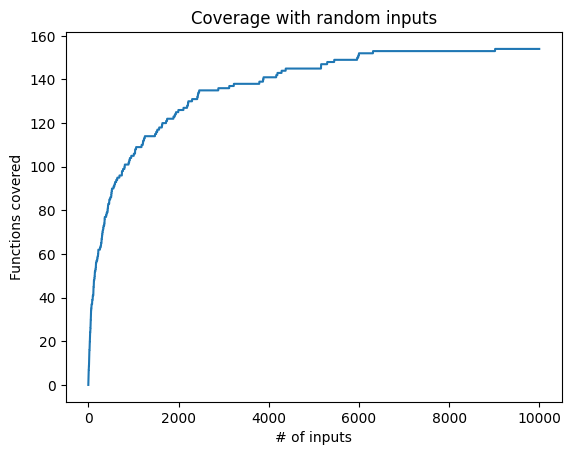

Bug discovery rate: 0.00 bugs/second
Average time per cycle in seconds 0.00615 seconds


In [14]:
cumulative_coverage, validation = zip(*mutation_fuzzer.cumulative_coverage)

plt.figure()
plt.plot(range(len(cumulative_coverage)), cumulative_coverage)
plt.title('Coverage with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('Functions covered')
plt.show()

print(mutation_fuzzer.bug_rate())
print(f"Average time per cycle in seconds {mutation_fuzzer.avg_time_per_cycle():.5f} seconds")

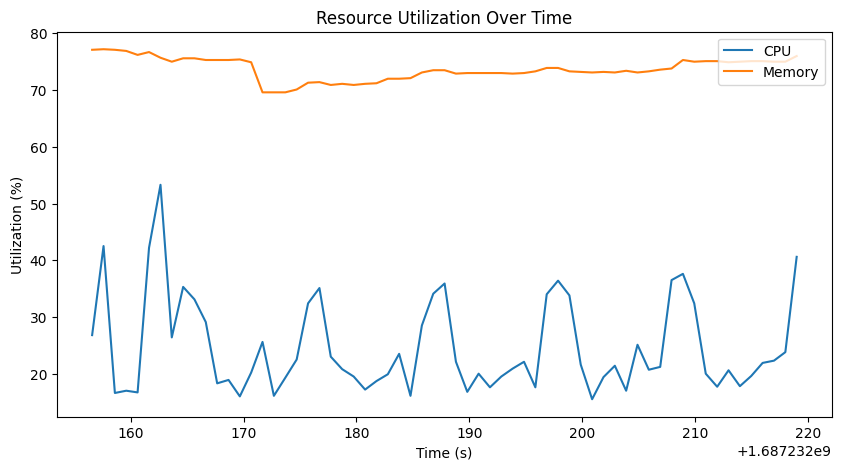

In [15]:
monitor.stop()
monitor.plot()